#FACED imaging cytometry based biophysical features: MCF7 Cell Cycle

In [4]:
import Viav030 as via
import pandas as pd
import numpy as np
import scanpy as sc
import umap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Load the feature matrix and known phase labels. M1 denotes G1 phase, M2 denotes S phase and M3 denotes M/G2 phase

In [5]:
df=pd.read_csv('/home/shobi/Trajectory/Datasets/FACED/mcf7_38features.csv')
df = df.drop('Unnamed: 0', 1)

true_label = pd.read_csv('/home/shobi/Trajectory/Datasets/FACED/mcf7_phases.csv')
true_label = list(true_label['phase'].values.flatten())
print('There are ', len(true_label), 'MCF7 cells and ', df.shape[1], 'features')

There are  2036 MCF7 cells and  38 features


In [8]:
ad = sc.AnnData(df)
ad.var_names = df.columns
#normalize features
sc.pp.scale(ad)

sc.tl.pca(ad, svd_solver='arpack')
# Weight the top features (ranked by Mutual Information and Random Forest Classifier)
X_in = ad.X  
df_X = pd.DataFrame(X_in)
df_X.columns = df.columns

df_X['Area'] = df_X['Area'] * 3
df_X['Dry Mass'] = df_X['Dry Mass'] * 3
df_X['Volume'] = df_X['Volume'] * 20

X_in = df_X.values
ad = sc.AnnData(df_X)
#apply PCA
sc.tl.pca(ad, svd_solver='arpack')
ad.var_names = df_X.columns

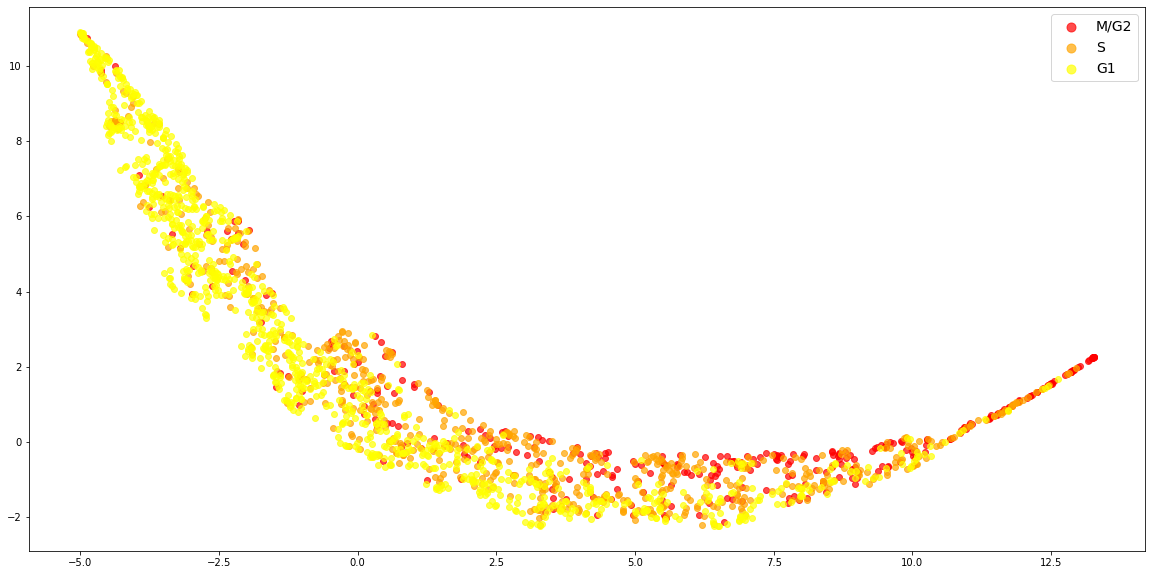

In [9]:
f, ax = plt.subplots(figsize = [20,10])

embedding = umap.UMAP().fit_transform(ad.obsm['X_pca'][:, 0:20])
#phate_op = phate.PHATE()
# embedding = phate_op.fit_transform(X_in)



cell_dict = {'T1_M1': 'yellow', 'T2_M1': 'yellowgreen', 'T1_M2': 'orange', 'T2_M2': 'darkgreen', 'T1_M3': 'red',
             'T2_M3': 'blue'}
cell_phase_dict = {'T1_M1': 'G1', 'T2_M1': 'G1', 'T1_M2': 'S', 'T2_M2': 'S', 'T1_M3': 'M/G2', 'T2_M3': 'M/G2'}

for key in list(set(true_label)):  # ['T1_M1', 'T2_M1','T1_M2', 'T2_M2','T1_M3', 'T2_M3']:
    loc = np.where(np.asarray(true_label) == key)[0]
    ax.scatter(embedding[loc, 0], embedding[loc, 1], c=cell_dict[key], alpha=.7, label=cell_phase_dict[key])
plt.legend(markerscale=1.5, fontsize=14)
plt.show()

input data has shape 2036 (samples) x 38 (features)


time is Mon Apr 12 14:55:31 2021
commencing global pruning
Share of edges kept after Global Pruning 65.13 %
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 


size neighbor array in low-KNN in pca-space for visualization (2036, 4)
commencing community detection
time is Mon Apr 12 14:55:32 2021
16  clusters before handling small/big
There are 0 clusters that are too big
number of components before pruning 1
there are  1 components in the graph
root user ['T1_M1']
new root is 0  with degree 10.86 T1_M1
new root is 10  with degree 6.10 T1_M1
start computing lazy-teleporting Expected Hitting Times


ended all multiprocesses, will retrieve and reshape
closeness  shortlist [0, 2, 10, 11, 12, 13]
betweeness shortlist [9, 10, 11, 12, 13]
out degree shortlist [0, 2, 7, 9, 12, 13]
TS 2 had 2 or more neighboring terminal states, namely [9, 12]  and so we removed, 9
TS 12 had 2 or more neighboring terminal states, namely [2, 13]  and so we removed, 12
terminal clus in this component [2, 13]
final terminal clus [2, 13]


From root 10  to Terminal state 2 is found 500  times.


From root 10  to Terminal state 13 is found 500  times.
terminal clusters [2, 13]
project onto single cell
start single cell projections of pseudotime and lineage likelihood


number of components before pruning 1


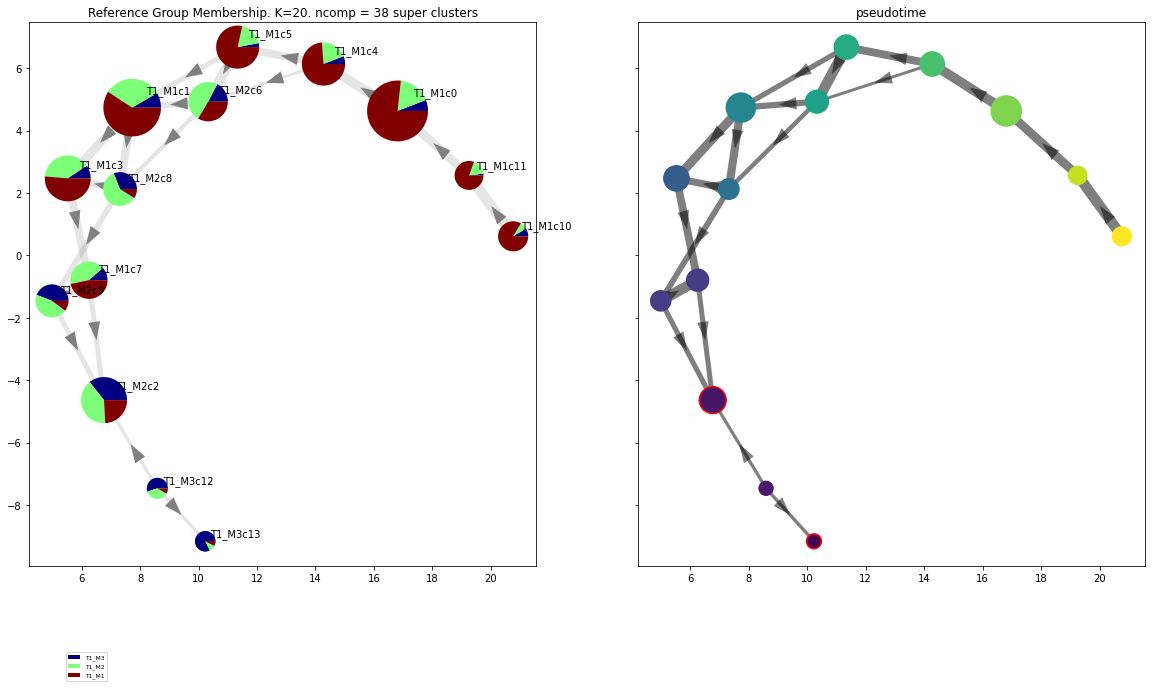

time elapsed 5.8 seconds


In [11]:
knn=20
jac_std_global = 0.5
random_seed = 1
root_user = ['T1_M1']
v0 = via.VIA(X_in, true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
         too_big_factor=0.3, root_user=root_user, dataset='faced', random_seed=random_seed,
         do_impute_bool=True, is_coarse=True, preserve_disconnected=True, preserve_disconnected_after_pruning=True,
         pseudotime_threshold_TS=40) 
v0.run_VIA()

input data has shape 2036 (samples) x 38 (features)


time is Mon Apr 12 14:55:41 2021
commencing global pruning
Share of edges kept after Global Pruning 65.13 %
commencing community detection
time is Mon Apr 12 14:55:41 2021
16  clusters before handling small/big
There are 11 clusters that are too big
too big is True  cluster 0 will be Expanded
cluster 9 is too big with population 104 . It will be expanded


cluster 8 is too big with population 118 . It will be expanded
cluster 7 is too big with population 122 . It will be expanded
cluster 6 is too big with population 139 . It will be expanded
cluster 5 is too big with population 148 . It will be expanded
cluster 4 is too big with population 167 . It will be expanded


cluster 3 is too big with population 168 . It will be expanded
cluster 2 is too big with population 181 . It will be expanded
cluster 1 is too big with population 182 . It will be expanded
cluster 0 is too big with population 237 . It will be expanded


number of components before pruning 1
there are  1 components in the graph
root user ['T1_M1']
new root is 0  with degree 15.99 and super node degree 11.01
new root is 3  with degree 23.26 and super node degree 10.86
new root is 10  with degree 22.62 and super node degree 6.10
start computing lazy-teleporting Expected Hitting Times


ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [2, 13]
terminal clus in this component [52, 2]
final terminal clus [52, 2]


From root 10  to Terminal state 52 is found 390  times.


From root 10  to Terminal state 2 is found 5  times.
terminal clusters [52, 2]
project onto single cell
start single cell projections of pseudotime and lineage likelihood


number of components before pruning 1
number of connected componnents after reconnecting  1


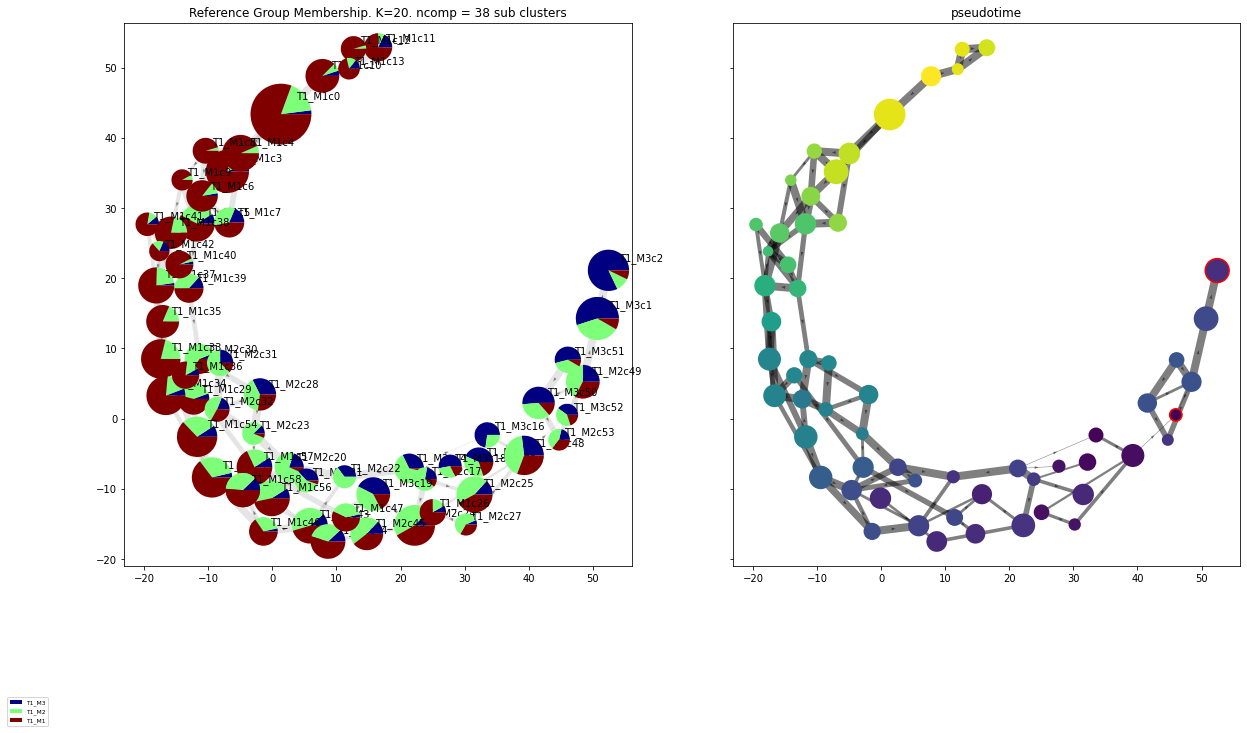

time elapsed 17.3 seconds


In [12]:
tsi_list = via.get_loc_terminal_states(v0, X_in)

v1 = via.VIA(X_in, true_label, jac_std_global=jac_std_global, dist_std_local=1, knn=knn,
         too_big_factor=0.05, super_cluster_labels=v0.labels, super_node_degree_list=v0.node_degree_list,
         super_terminal_cells=tsi_list, root_user=root_user, is_coarse=False,
         preserve_disconnected=True, dataset='faced',
         super_terminal_clusters=v0.terminal_clusters, random_seed=random_seed,
         full_neighbor_array=v0.full_neighbor_array, full_distance_array=v0.full_distance_array,
         ig_full_graph=v0.ig_full_graph,
         csr_array_locally_pruned=v0.csr_array_locally_pruned, pseudotime_threshold_TS=40)
v1.run_VIA()

dict of terminal state pairs, Super: sub:  {2: 52, 13: 2}


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

super cluster 2 is a super terminal with sub_terminal cluster 52
super cluster 13 is a super terminal with sub_terminal cluster 2


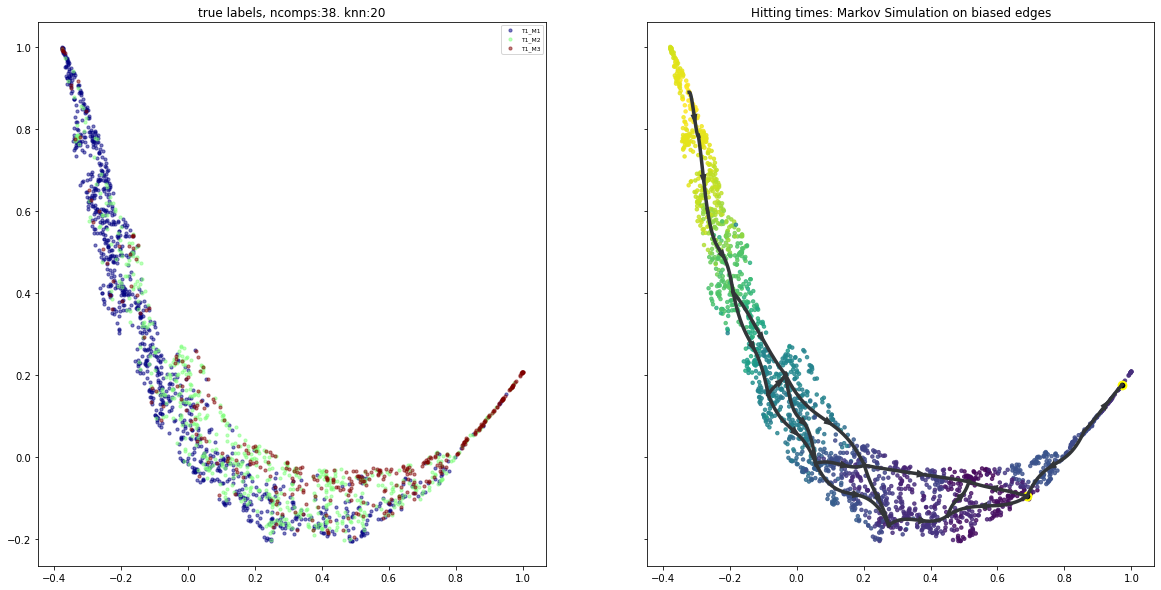

In [ ]:
super_clus_ds_PCA_loc = via.sc_loc_ofsuperCluster_PCAspace(v0, v1, np.arange(0, len(v0.labels)))
via.draw_trajectory_gams(embedding, super_clus_ds_PCA_loc, v1.labels, v0.labels, v0.edgelist_maxout,
                     v1.x_lazy, v1.alpha_teleport, v1.single_cell_pt_markov, true_label, knn=v0.knn,
                     final_super_terminal=v1.revised_super_terminal_clusters,
                     sub_terminal_clusters=v1.terminal_clusters,
                     title_str='Hitting times: Markov Simulation on biased edges', ncomp = 38, arrow_width_scale_factor=20)
plt.show()

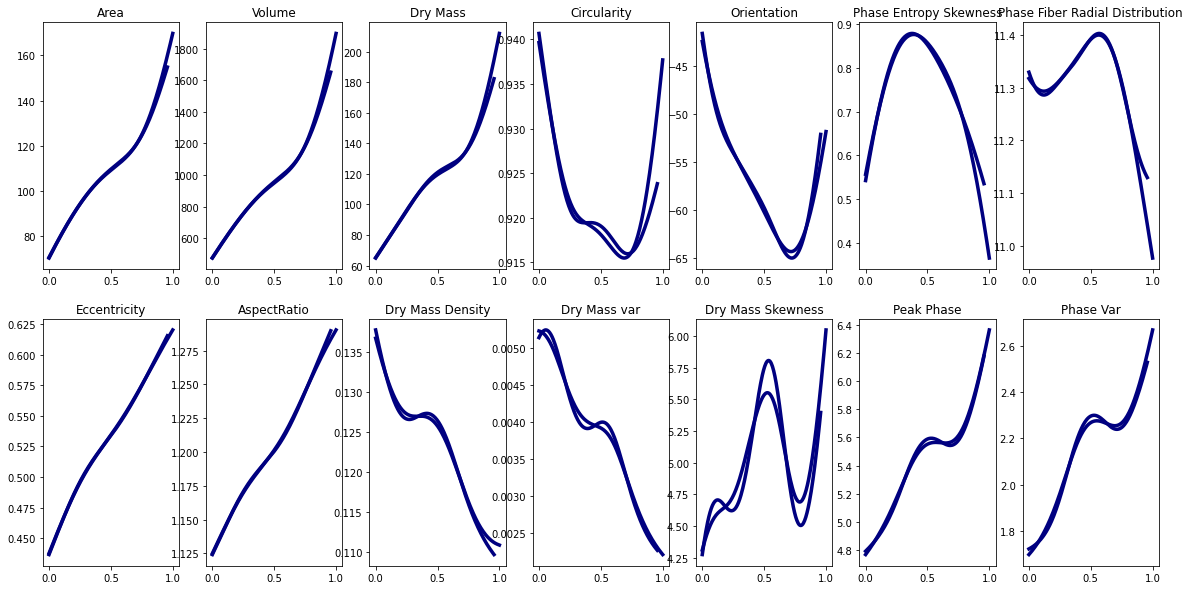

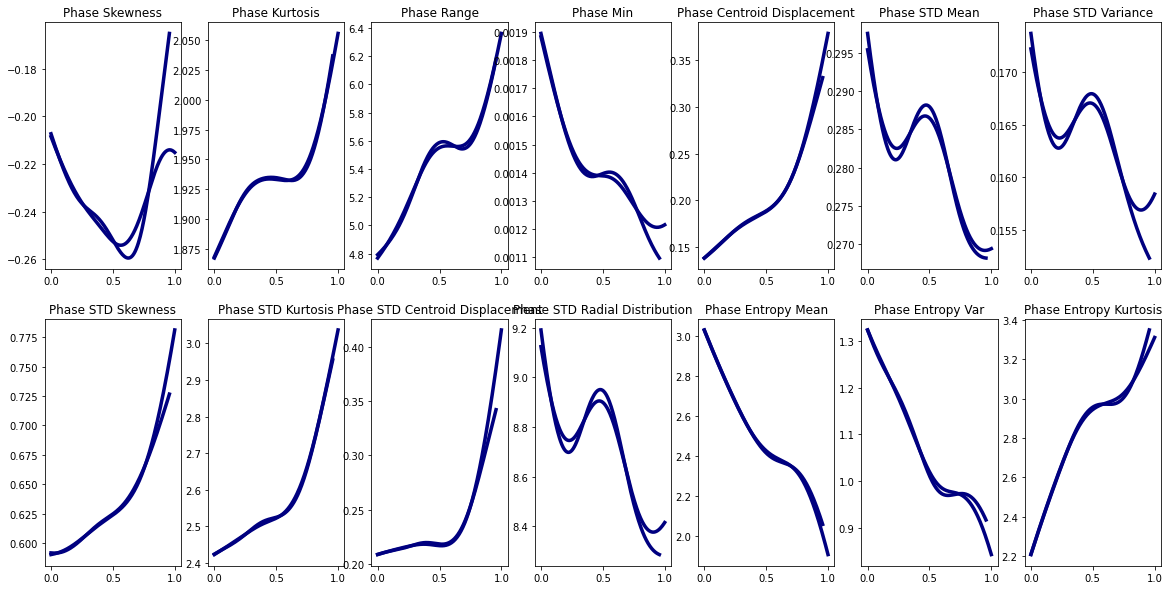

In [12]:
all_cols = ['Area', 'Volume', 'Dry Mass', 'Circularity', 'Orientation', 'Phase Entropy Skewness',
                'Phase Fiber Radial Distribution', 'Eccentricity', 'AspectRatio', 'Dry Mass Density', 'Dry Mass var',
                'Dry Mass Skewness', 'Peak Phase', 'Phase Var', 'Phase Skewness', 'Phase Kurtosis', 'Phase Range',
                'Phase Min', 'Phase Centroid Displacement', 'Phase STD Mean', 'Phase STD Variance',
                'Phase STD Skewness', 'Phase STD Kurtosis', 'Phase STD Centroid Displacement',
                'Phase STD Radial Distribution', 'Phase Entropy Mean', 'Phase Entropy Var', 'Phase Entropy Kurtosis',
                'Phase Entropy Centroid Displacement', 'Phase Entropy Radial Distribution',
                'Phase Fiber Centroid Displacement', 'Phase Fiber Pixel >Upper Percentile', 'Phase Fiber Pixel >Median',
                'Mean Phase Arrangement', 'Phase Arrangement Var', 'Phase Arrangement Skewness',
                'Phase Orientation Var', 'Phase Orientation Kurtosis']
plot_n = 7
fig, axs = plt.subplots(2, plot_n, figsize = [20,10])  # (2,10)
for enum_i, pheno_i in enumerate(all_cols[0:14]):  # [0:14]
    subset_ = df[pheno_i].values

    if enum_i >= plot_n:
        row = 1
        col = enum_i - plot_n
    else:
        row = 0
        col = enum_i
    ax = axs[row, col]
    v0.get_gene_expression_multi(ax=ax, gene_exp=subset_, title_gene=pheno_i)


fig2, axs2 = plt.subplots(2, plot_n,figsize = [20,10])
for enum_i, pheno_i in enumerate(all_cols[2*plot_n:2*plot_n+14]):
    subset_ = df[pheno_i].values

    if enum_i >= plot_n:
        row = 1
        col = enum_i - plot_n
    else:
        row = 0
        col = enum_i

    ax2 = axs2[row, col]
    v0.get_gene_expression_multi(ax=ax2, gene_exp=subset_, title_gene=pheno_i)

plt.show()